In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array

# Load data

In [27]:
image_folder = "/Users/liliane.bader/Documents/AU/DLfVR/project/data/archive/HAM10000_images_part_1/"
metadata_path = "/Users/liliane.bader/Documents/AU/DLfVR/project/data/archive/HAM10000_metadata.csv"

metadata = pd.read_csv(metadata_path)
metadata['image_path'] = metadata['image_id'].apply(lambda x: os.path.join(image_folder, f"{x}.jpg"))
metadata_part1 = metadata[(metadata['image_id'] > 'ISIC_0024305') & (metadata['image_id'] < 'ISIC_0029306')]

# Load images and preprocess them
image_size = (64, 64)  

def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=image_size)
    img = img_to_array(img) / 255.0  # Normalize to [0,1]
    return img

# Load all images into a list and convert to a numpy array
images_part1 = np.array([load_and_preprocess_image(img_path) for img_path in metadata_part1['image_path']])
print(images_part1.shape) 

(5000, 224, 224, 3)


In [28]:
labels_part1 = metadata_part1['dx']
# make dictionary to assign a unique integer index to each unique label 
# string to numerical
label_mapping = {label: idx for idx, label in enumerate(labels_part1.unique())}
# replaces each original label (from dx) with its corresponding integer value
metadata_part1.loc[:, 'label'] = metadata_part1['dx'].map(label_mapping)
# convert integer labels into a binary (one-hot) matrix 
labels_encoded = to_categorical(metadata_part1['label'])
print(metadata_part1['label'].head(10))
print(metadata_part1['dx'].unique())
print(metadata_part1['label'].value_counts())

0     0
1     0
2     0
3     0
5     0
6     0
7     0
8     0
9     0
10    0
Name: label, dtype: int64
['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
label
1    3431
0     564
3     435
5     266
6     183
4      65
2      56
Name: count, dtype: int64


/var/folders/zt/fk8vkvl57m1ghjg3p98gjq5r0000gp/T/ipykernel_86412/3816237097.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_part1.loc[:, 'label'] = metadata_part1['dx'].map(label_mapping)


In [18]:
# Split data into training and testing sets
# 80% training, 20% testing
# x = images, y = labels
X_train, X_test, y_train, y_test = train_test_split(images_part1, labels_encoded, test_size=0.2, random_state=42)


# Define a simple baseline model (CNN)

In [23]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_mapping), activation='softmax')  # Output layer for classification
])

/Users/liliane.bader/Documents/AU/DLfVR/project/deeplproject/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6688 - loss: 1.1748 - val_accuracy: 0.6650 - val_loss: 0.9739
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7091 - loss: 0.8875 - val_accuracy: 0.6730 - val_loss: 0.8799
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7192 - loss: 0.8374 - val_accuracy: 0.6690 - val_loss: 0.9108
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7046 - loss: 0.8056 - val_accuracy: 0.6880 - val_loss: 0.8548
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7125 - loss: 0.7919 - val_accuracy: 0.6890 - val_loss: 0.8411
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7341 - loss: 0.7426 - val_accuracy: 0.6910 - val_loss: 0.8218
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7326 - loss: 0.7338 - val_accuracy: 0.7010 - val_loss: 0.8079
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7468 - loss: 0.6980 - val_accu

In [26]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7163 - loss: 0.7635
Test Accuracy: 0.7200


In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

# Simple Model using ResNet 

In [2]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize

In [3]:
# Load the metadata
metadata_path = "/Users/liliane.bader/Documents/AU/DLfVR/project/data/archive/HAM10000_metadata.csv"
metadata = pd.read_csv(metadata_path)

# Create a label mapping from 'dx' column
#label_mapping = {label: idx for idx, label in enumerate(metadata['dx'].unique())}
#metadata['label'] = metadata['dx'].map(label_mapping)

# Check the label distribution
#print(metadata['label'].value_counts())
print(metadata['dx'].value_counts())

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [5]:
# Load the image data
# Image directories
image_folder_1 = "/Users/liliane.bader/Documents/AU/DLfVR/project/data/archive/HAM10000_images_part_1/"
image_folder_2 = "/Users/liliane.bader/Documents/AU/DLfVR/project/data/archive/HAM10000_images_part_2/"

# Combine paths of images from both parts
metadata['image_path'] = metadata['image_id'].apply(lambda x: 
    os.path.join(image_folder_1, x + ".jpg") 
    if os.path.exists(os.path.join(image_folder_1, x + ".jpg"))
    else os.path.join(image_folder_2, x + ".jpg")
)

print(metadata)

         lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                              image_path  
0   

In [8]:
# For some lesion ID's there are multiple images.
# A dataset with only one image per ID would be more ideal.
unique_data = metadata.groupby('lesion_id').first().reset_index()

print(unique_data.head())
print(len(unique_data))
# 10015-7470 = 2545 duplications

     lesion_id      image_id   dx    dx_type   age     sex     localization  \
0  HAM_0000000  ISIC_0028498   nv      histo  60.0    male             back   
1  HAM_0000001  ISIC_0027859  bkl      histo  70.0  female             face   
2  HAM_0000002  ISIC_0033848  mel      histo  65.0  female  lower extremity   
3  HAM_0000003  ISIC_0027886   nv  follow_up  55.0    male            trunk   
4  HAM_0000004  ISIC_0024645   nv  follow_up  40.0  female             back   

                                          image_path  
0  /Users/liliane.bader/Documents/AU/DLfVR/projec...  
1  /Users/liliane.bader/Documents/AU/DLfVR/projec...  
2  /Users/liliane.bader/Documents/AU/DLfVR/projec...  
3  /Users/liliane.bader/Documents/AU/DLfVR/projec...  
4  /Users/liliane.bader/Documents/AU/DLfVR/projec...  
7470


In [9]:
# subset data
# Apply the sample while ensuring that the original columns are preserved
subset_data = unique_data.groupby('dx', group_keys=False).apply(
    lambda x: x.sample(frac=0.2, random_state=42)
).reset_index(drop=True)


print(f"Original data size: {len(unique_data)}")
print(f"Subset data size: {len(subset_data)}")
print(subset_data.head())

Original data size: 7470
Subset data size: 1495
     lesion_id      image_id     dx dx_type   age     sex     localization  \
0  HAM_0007047  ISIC_0025957  akiec   histo  60.0  female  lower extremity   
1  HAM_0002070  ISIC_0028659  akiec   histo  70.0  female  upper extremity   
2  HAM_0000498  ISIC_0029067  akiec   histo  65.0    male  upper extremity   
3  HAM_0006524  ISIC_0031228  akiec   histo  65.0    male              ear   
4  HAM_0000688  ISIC_0026720  akiec   histo  75.0    male  lower extremity   

                                          image_path  
0  /Users/liliane.bader/Documents/AU/DLfVR/projec...  
1  /Users/liliane.bader/Documents/AU/DLfVR/projec...  
2  /Users/liliane.bader/Documents/AU/DLfVR/projec...  
3  /Users/liliane.bader/Documents/AU/DLfVR/projec...  
4  /Users/liliane.bader/Documents/AU/DLfVR/projec...  


/var/folders/zt/fk8vkvl57m1ghjg3p98gjq5r0000gp/T/ipykernel_64370/914719222.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset_data = unique_data.groupby('dx', group_keys=False).apply(


In [10]:
# Splitting data
# 70% train, 30% temp (validation + test)
train_data, temp_data = train_test_split(subset_data, stratify=subset_data['dx'], test_size=0.3, random_state=42)

# From the 30% temp, allocate 50% to validation and 50% to test (15% each of the total data)
val_data, test_data = train_test_split(temp_data, stratify=temp_data['dx'], test_size=0.5, random_state=42)

# Print the sizes of the splits
print(f"Train set: {len(train_data)}")
print(f"Validation set: {len(val_data)}")
print(f"Test set: {len(test_data)}")

Train set: 1046
Validation set: 224
Test set: 225


In [11]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224), # (128, 128)
    class_mode='categorical',
    batch_size=32 # 32 # 16
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_data,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

Found 1046 validated image filenames belonging to 7 classes.
Found 224 validated image filenames belonging to 7 classes.
Found 225 validated image filenames belonging to 7 classes.


In [12]:
# Learning rate optimizers
# Set up sgd optimizer
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100,
    decay_rate=1e-6)
sgd_optimizer = optimizers.SGD(learning_rate=lr_schedule,momentum=0.9, nesterov=True)


In [13]:
# Load the pre-trained ResNet50 model, excluding the top classification layer
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the ResNet50 base layers so they won't be trained
for layer in resnet_model.layers:
    layer.trainable = False

# Create a new model on top of ResNet50
model = Sequential([
    resnet_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# Adam(learning_rate=0.0001)

# Check model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
# manually control stepsize
step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = val_generator.n//val_generator.batch_size # Number of mini-batches per epoch (validation)

# Train the model
# Put data into the model
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator), #step_size_train, #len(train_generator),
    validation_steps=len(val_generator) #step_size_val, #len(val_generator)
)

Epoch 1/10


/Users/liliane.bader/Documents/AU/DLfVR/project/deeplproject/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6186 - loss: 1.3199 - val_accuracy: 0.7009 - val_loss: 0.9936
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


2024-11-19 14:47:30.069549: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/liliane.bader/.pyenv/versions/3.9.10/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-19 14:47:30.083211: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7214 - loss: 0.8656 - val_accuracy: 0.7009 - val_loss: 0.9837
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10


2024-11-19 14:48:08.468929: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7431 - loss: 0.8740 - val_accuracy: 0.7009 - val_loss: 0.9832
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7163 - loss: 0.9213 - val_accuracy: 0.7009 - val_loss: 0.9832
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10


2024-11-19 14:49:25.559014: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7082 - loss: 0.9485 - val_accuracy: 0.7009 - val_loss: 0.9832
Epoch 10/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


## Plot model performance

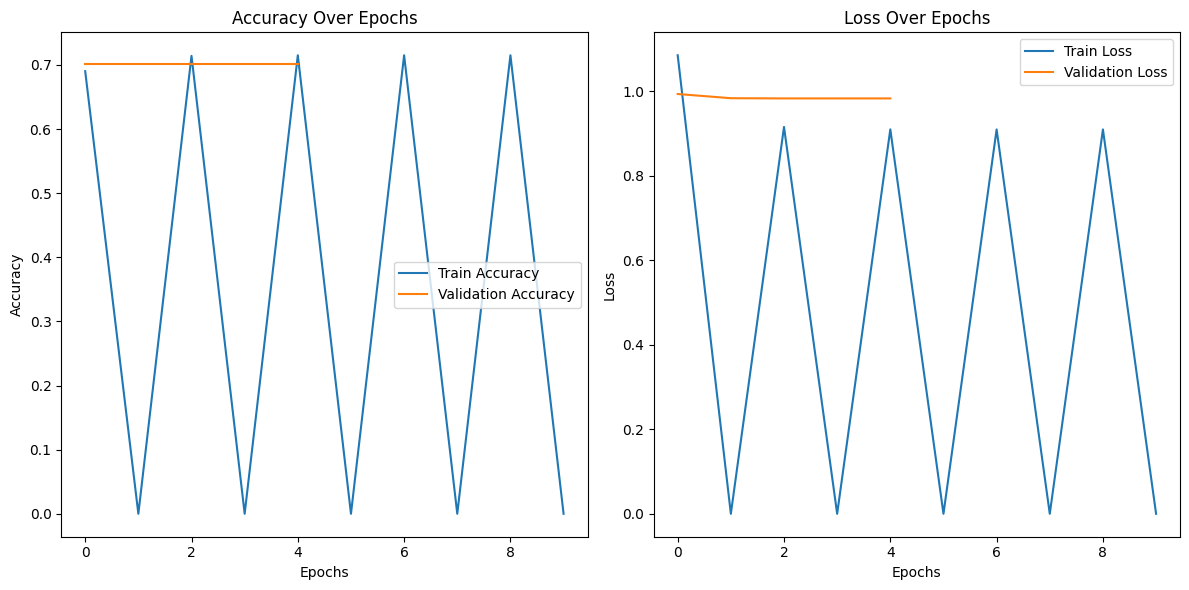

In [15]:
# Plotting loss and accuracy curves
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with the model's history
plot_training_history(history)

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 834ms/step


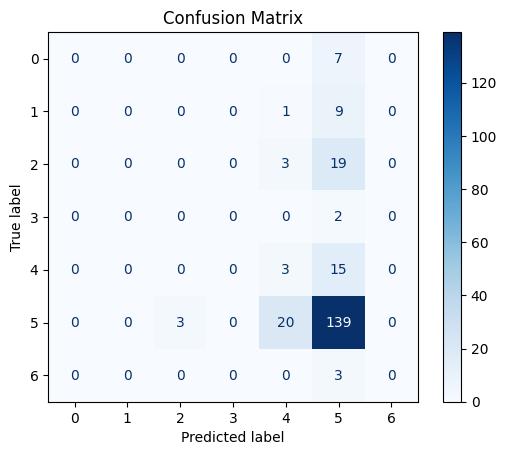

In [16]:
# Confusion matrix
# Predict on the validation set
y_true = val_generator.classes
y_pred = model.predict(val_generator, steps=len(val_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [17]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00         2
           4       0.11      0.17      0.13        18
           5       0.72      0.86      0.78       162
           6       0.00      0.00      0.00         3

    accuracy                           0.63       224
   macro avg       0.12      0.15      0.13       224
weighted avg       0.53      0.63      0.58       224



/Users/liliane.bader/Documents/AU/DLfVR/project/deeplproject/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/liliane.bader/Documents/AU/DLfVR/project/deeplproject/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/liliane.bader/Documents/AU/DLfVR/project/deeplproject/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

In [18]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

/Users/liliane.bader/Documents/AU/DLfVR/project/deeplproject/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 718ms/step - accuracy: 0.7094 - loss: 1.0420
Test Loss: 1.0138554573059082
Test Accuracy: 0.6888889074325562
